## Background Selection Simulations

In [26]:
import os`
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import pickle
from multiprocessing import Pool
from functools import partial
import pandas as pd
import scipy
import random
from operator import itemgetter
from collections import defaultdict
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.colors as mcolors

In [28]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.slimfile as sf
from cvtk.gintervals import GenomicIntervals
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.process_sims import extract_runs, load_pickled, load_stats, CI_polygon
from cvtk.process_sims import params_vary_over, col_palette, average_runs
from cvtk.utils import integerize
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [29]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200
plt.style.use('plots/buffalo.mplstyle')

ONECOL = 3.42
THREEHALVESCOL = 4.5
TWOCOL = 7

In [30]:
DATADIR_WF = "../data/sims_intermediate/bgs/with_fixations/"
DATADIR_WOF = "../data/sims_intermediate/bgs/without_fixations/"
SIMDIR = "../data/sims/bgs/"

In [31]:
converters = dict(N=int, U=float, nmu=float, rbp=float, s=float,
                  region_length=int)

bgs_results_wof = load_pickled(DATADIR_WOF, converters=converters)
bgs_results_wf = load_pickled(DATADIR_WF, converters=converters)
bgs_stats = load_stats(SIMDIR, pattern="bgs_1000N_(1e-08|1e-07)rbp.*(0.5|1|1.5)U.*", 
                       converters=converters)

## Verifying our BGS Simulations by Comparing to Hudson and Kaplan Theory

We get the average neutral heterozygosity in a region in the last generation and compare to the Hudson and Kaplan theory.

In [32]:
@np.vectorize
def HK95(μ, N, L, U):
    """Hudson and Kaplan (1995) theory.
    μ: mutation rate
    N: number of diploids
    U: genome-wide deleterious mutation rate
    L: recombination map length
    """
    return 4 * μ * N * np.exp(-U / L)

In [33]:
def calc_ave_neut_het(stats):
    max_gen = stats['gen'].max()
    return stats[stats['gen'] == max_gen].mean()['neut_het']

In [34]:
def unset(x):
    assert(len(x) == 1)
    return list(x)[0]

In [35]:
def stats_to_dataframe(x):
    out = []
    for key, reps in x.items():
        for r, stats in enumerate(reps):
            n = stats.shape[0]
            params = pd.DataFrame([dict(key)] * n)
            d = pd.concat((params, stats), axis=1)        
            out.append(d)
    return pd.concat(out)

In [36]:
stats_df = stats_to_dataframe(bgs_stats)

In [37]:
df = stats_df[stats_df['gen'] == stats_df['gen'].max()]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


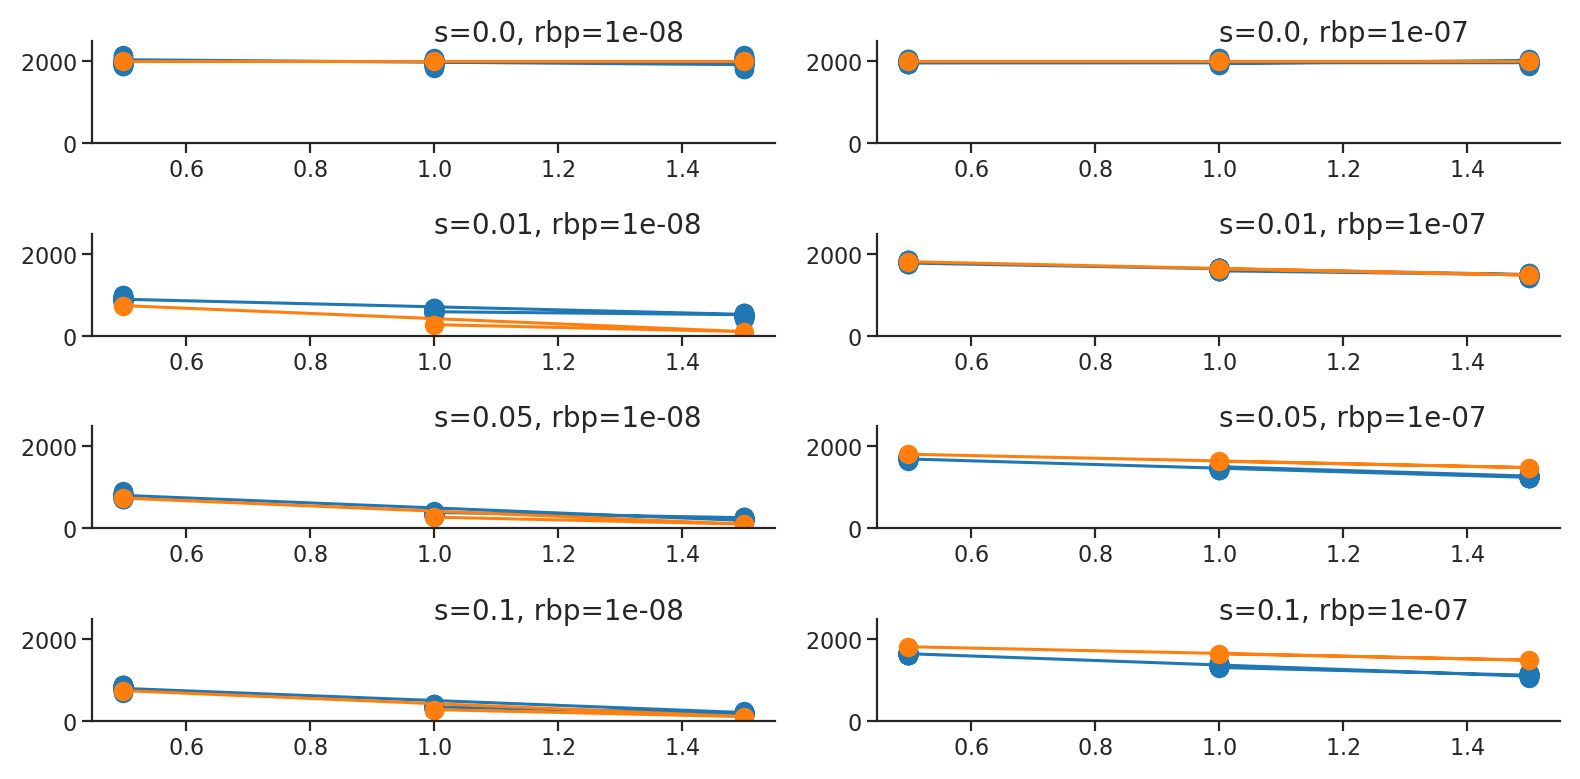

In [38]:
ss, rbps = sorted(df['s'].unique()), sorted(df['rbp'].unique())

fig, ax = plt.subplots(len(ss), len(rbps), sharey='col')

for i, s in enumerate(ss):
    for j, rbp in enumerate(rbps):
        d = df[(df['rbp'] == rbp) & (df['s'] == s)]

        nmu = d['nmu'].unique()
        rl = d['region_length'].unique()
        N = d['N'].unique()
        L = rbp * rl
        U = d['U'].unique()
        
        assert(len(nmu) == 1 and len(rl) == 1 and len(N) == 1) 
        
        ax[i, j].plot(d['U'], d['neut_het'], '-o')
        ax[i, j].text(0.5, 1, f"s={s}, rbp={rbp}", transform=ax[i, j].transAxes)
        ssh = HK95(nmu * rl, N, L, U) if s > 0 else np.repeat(4 * N * nmu * rl, len(U))
        ax[i, j].plot(U, ssh, '-o')
        ax[i, j].set_ylim(-1, 2.5e3)
plt.tight_layout()

## G Through Time

Note, we exclude the s variable, since this is almost certaintly a bug (no oether neutral sims show this; compare exp. directional selection VA = 0).

In [39]:
stacked_results_wof = average_runs(bgs_results_wof, has_corr=False)

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


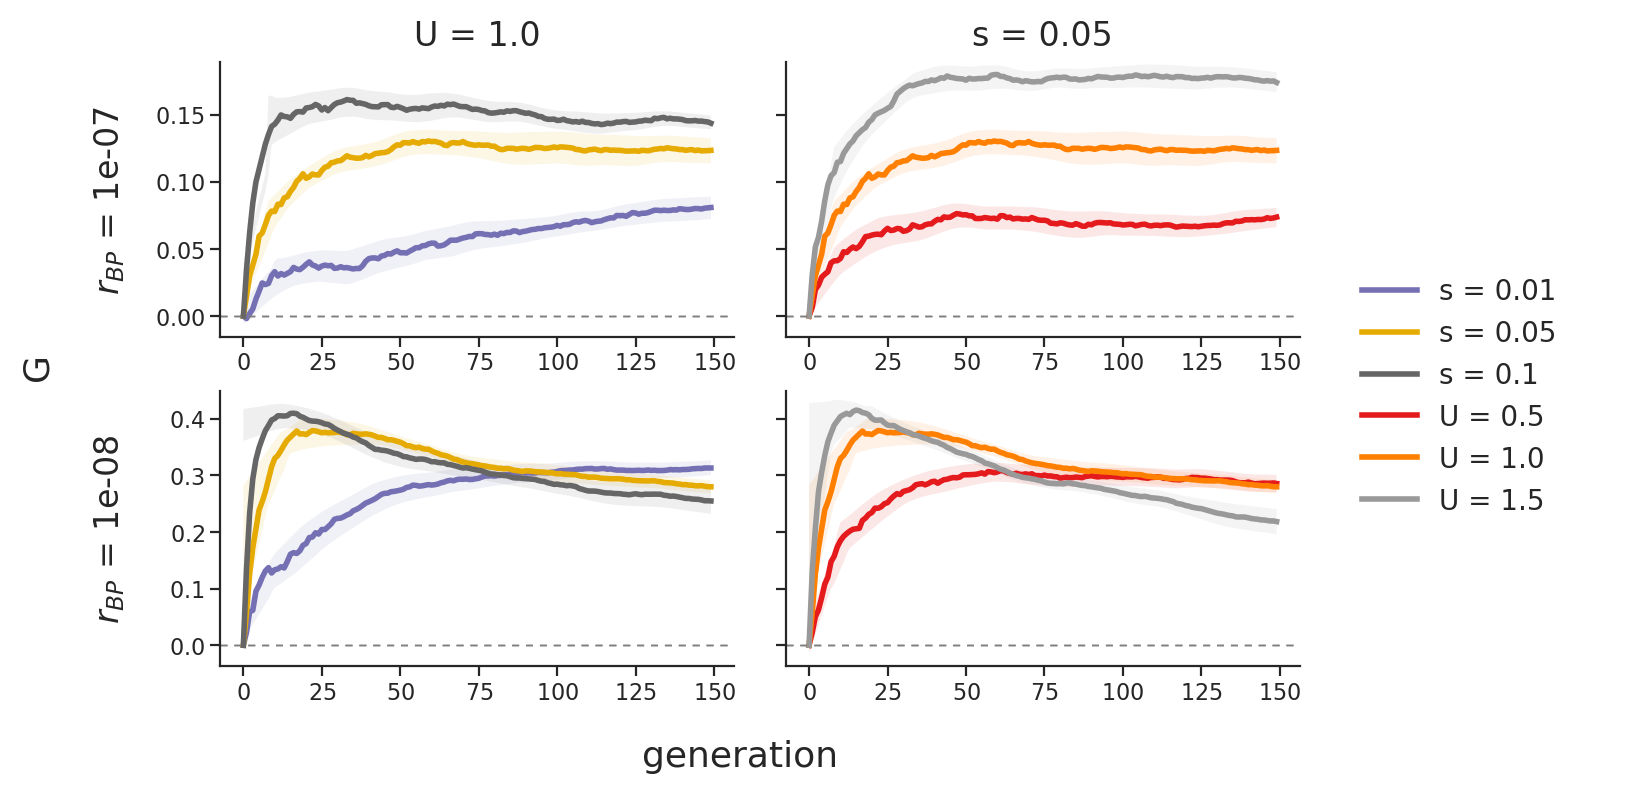

In [60]:
CI_ALPHA = 0.1
param_covs = params_vary_over(bgs_results_wof)
rbps = param_covs['rbp']
s_cols = col_palette(param_covs['s'], cm.Dark2)
U_cols = col_palette(param_covs['U'], cm.Set1)

fig, ax = plt.subplots(ncols=2, nrows=2, sharey='row')

# crap you need to do because matplotlib...
labset = set()
pad = 5

for i, rbp in enumerate(rbps):
    stacked_results_rbp = extract_runs({'rbp': [rbp]}, stacked_results_wof)

    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['U'] != 1.0 or params['s'] == 0.:
            continue

        G = Gs.mean(axis=0)
        G_sim = np.quantile(Gs, (0.05, 0.95), axis=0)
        
        G_sd = np.sqrt(np.var(Gs, axis=0))
        N = Gs.shape[0]
        G_CI = np.stack((G - 2 * G_sd/np.sqrt(N), 
                           G + 2 * G_sd/np.sqrt(N)))
        G_poly = CI_polygon(np.arange(G.shape[0]), 
                            G_CI[0, :, 0], G_CI[1, :, 0],
                            color=s_cols[params['s']], alpha=CI_ALPHA,
                            linewidth=0)        
        lab = f"s = {params['s']}" if params['s'] not in labset and i == 0 else ""
        labset.add(params['s'])
        ax[i, 0].plot(G, c=s_cols[params['s']], label=lab, alpha=1, 
                      linewidth=2)
        ax[i, 0].add_patch(G_poly)
       
        #ax[i, 0].set_ylabel("G")
        if i == 0:
            ax[i, 0].set_title("U = 1.0")
        #else:
        #    ax[i, 0].set_xlabel("generation")
        ax[i, 0].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        #ax[i, 0].set_ylim(-0.1, 0.5)

    labset = set()

    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['s'] != 0.05:
            continue

        G = Gs.mean(axis=0)
        G_sim = np.quantile(Gs, (0.05, 0.95), axis=0)
        G_sd = np.sqrt(np.var(Gs, axis=0))
        N = Gs.shape[0]
        G_CI = np.stack((G - 2 * G_sd/np.sqrt(N), 
                           G + 2 * G_sd/np.sqrt(N)))      
        G_poly = CI_polygon(np.arange(G.shape[0]), 
                            G_CI[0, :, 0], G_CI[1, :, 0],
                            color=U_cols[params['U']], alpha=CI_ALPHA,
                            linewidth=0)

        lab = f"U = {params['U']}" if params['U'] not in labset and i == 0 else ""
        labset.add(params['U'])    
        ax[i, 1].plot(G, c=U_cols[params['U']], label=lab, alpha=1, linewidth=2)
        ax[i, 1].add_patch(G_poly)    
        #ax[i, 1].legend(frameon=False, ncol=2, loc=(0.1, -0.01))
        if i == 0:
            ax[i, 1].set_title("s = 0.05")
        #else:
        #    ax[i, 1].set_xlabel("generation")            
        #ax[i, 1].set_ylabel("G")
        ax[i, 1].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        #ax[i, 1].set_ylim(-0.1, 0.5)   


    ax[i, 0].annotate(f"$r_{{BP}}$ = {rbp}", xy=(-0.18, 0.5), 
                            xycoords="axes fraction",
                            size='large', ha='right', va='center', 
                            rotation=90)

fig.text(0, 0.5, "G", va="center", fontsize=13, rotation='vertical')
fig.text(0.45, 0, "generation", ha="center", fontsize=13)
fig.legend(loc = 7, frameon=False, ncol=1)
fig.subplots_adjust(right=0.8, wspace=0.1)
fig.savefig("plots/fig-bgs-G-without-fixations.pdf", bbox_inches='tight')

In [41]:
stacked_results_wf = average_runs(bgs_results_wf, has_corr=False)

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
Gs.shape

(30, 150, 1)

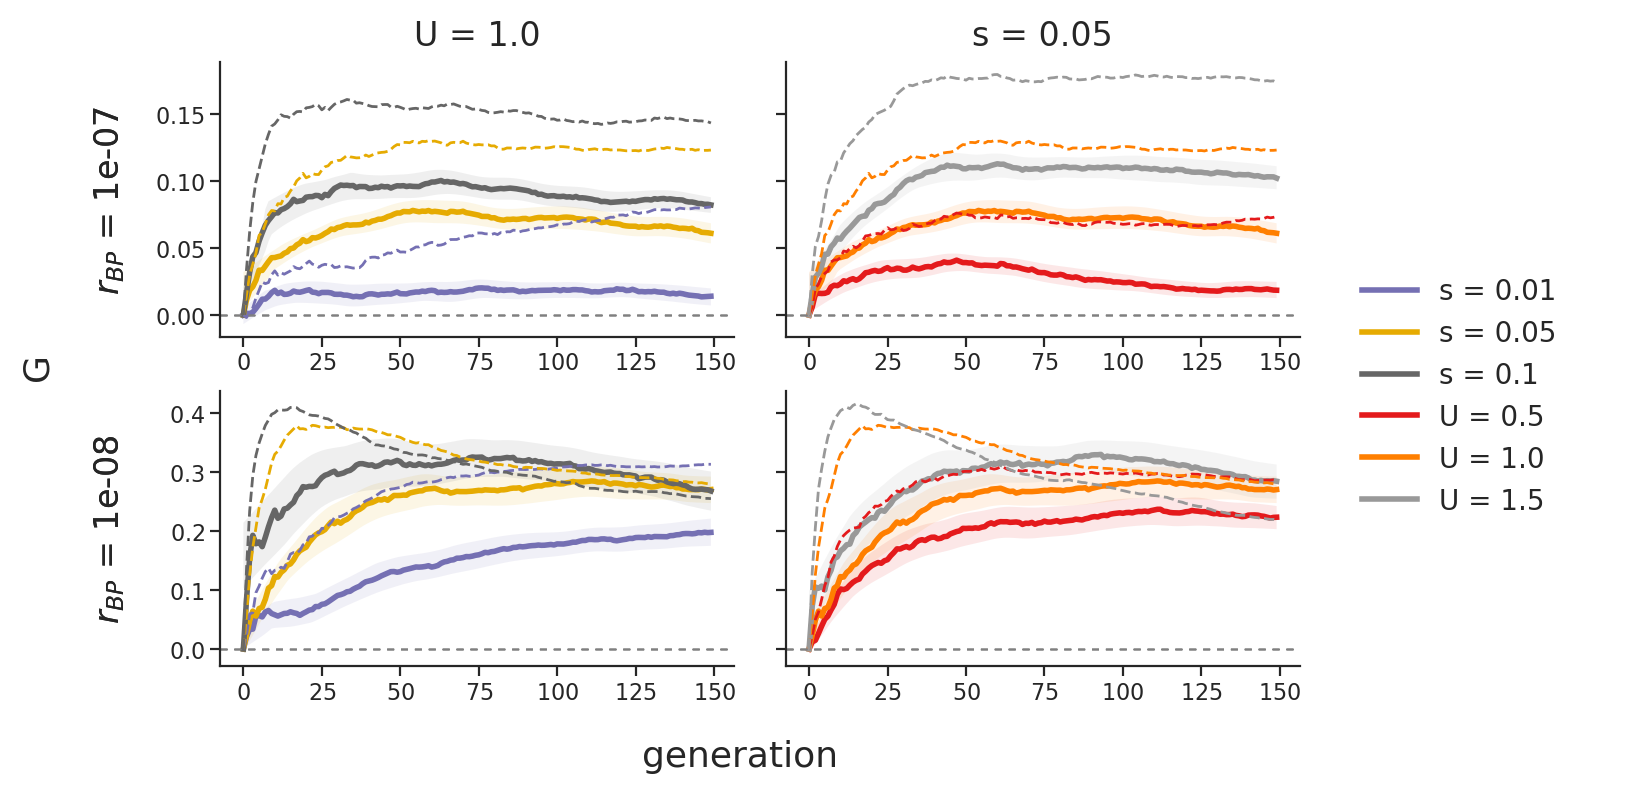

In [61]:
CI_ALPHA = 0.1
param_covs = params_vary_over(bgs_results_wf)
rbps = param_covs['rbp']
s_cols = col_palette(param_covs['s'], cm.Dark2)
U_cols = col_palette(param_covs['U'], cm.Set1)

fig, ax = plt.subplots(ncols=2, nrows=2, sharey='row')

# crap you need to do because matplotlib...
labset = set()
pad = 5

for i, rbp in enumerate(rbps):
    stacked_results_rbp = extract_runs({'rbp': [rbp]}, stacked_results_wf)

    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['U'] != 1.0 or params['s'] == 0:
            continue
        #Gs = Gs[:, 1:50, :]
        G = Gs.mean(axis=0)
        G_sim = np.quantile(Gs, (0.05, 0.95), axis=0)
        
        G_sd = np.sqrt(np.var(Gs, axis=0))
        N = Gs.shape[0]
        G_CI = np.stack((G - 2 * G_sd/np.sqrt(N), 
                           G + 2 * G_sd/np.sqrt(N)))
        G_poly = CI_polygon(np.arange(G.shape[0]), 
                            G_CI[0, :, 0], G_CI[1, :, 0],
                            color=s_cols[params['s']], alpha=CI_ALPHA,
                            linewidth=0)        
        lab = f"s = {params['s']}" if params['s'] not in labset and i == 0 else ""
        labset.add(params['s'])
        ax[i, 0].plot(G, c=s_cols[params['s']], label=lab, alpha=1, 
                      linewidth=2)
        ax[i, 0].add_patch(G_poly)
       
        #ax[i, 0].set_ylabel("G")
        if i == 0:
            ax[i, 0].set_title("U = 1.0")
        #else:
        #    ax[i, 0].set_xlabel("generation")
        ax[i, 0].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        #ax[i, 0].set_ylim(-0.1, 0.5)

    labset = set()

    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['s'] != 0.05:
            continue
        #Gs = Gs[:, 1:50, :]
        G = Gs.mean(axis=0)
        G_sim = np.quantile(Gs, (0.05, 0.95), axis=0)
        G_sd = np.sqrt(np.var(Gs, axis=0))
        N = Gs.shape[0]
        G_CI = np.stack((G - 2 * G_sd/np.sqrt(N), 
                           G + 2 * G_sd/np.sqrt(N)))      
        G_poly = CI_polygon(np.arange(G.shape[0]), 
                            G_CI[0, :, 0], G_CI[1, :, 0],
                            color=U_cols[params['U']], alpha=CI_ALPHA,
                            linewidth=0)

        lab = f"U = {params['U']}" if params['U'] not in labset and i == 0 else ""
        labset.add(params['U'])    
        ax[i, 1].plot(G, c=U_cols[params['U']], label=lab, alpha=1, linewidth=2)
        ax[i, 1].add_patch(G_poly)    
        #ax[i, 1].legend(frameon=False, ncol=2, loc=(0.1, -0.01))
        if i == 0:
            ax[i, 1].set_title("s = 0.05")
        #else:
        #    ax[i, 1].set_xlabel("generation")            
        #ax[i, 1].set_ylabel("G")
        ax[i, 1].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        #ax[i, 1].set_ylim(-0.1, 0.5)   


    ax[i, 0].annotate(f"$r_{{BP}}$ = {rbp}", xy=(-0.18, 0.5), 
                            xycoords="axes fraction",
                            size='large', ha='right', va='center', 
                            rotation=90)
    
# crap you need to do because matplotlib...
labset = set()
pad = 5

for i, rbp in enumerate(rbps):
    stacked_results_rbp = extract_runs({'rbp': [rbp]}, stacked_results_wof)

    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['U'] != 1.0 or params['s'] == 0:
            continue
        #Gs = Gs[:, 1:50, :]
        G = Gs.mean(axis=0)
        G_sim = np.quantile(Gs, (0.05, 0.95), axis=0)
        
        G_sd = np.sqrt(np.var(Gs, axis=0))
        N = Gs.shape[0]
        lab = f"s = {params['s']}" if params['s'] not in labset and i == 0 else ""
        labset.add(params['s'])
        ax[i, 0].plot(G, c=s_cols[params['s']],  alpha=1, 
                      linewidth=1, linestyle='--')
       
        #ax[i, 0].set_ylabel("G")
        if i == 0:
            ax[i, 0].set_title("U = 1.0")
        #else:
        #    ax[i, 0].set_xlabel("generation")
        ax[i, 0].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        #ax[i, 0].set_ylim(-0.1, 0.5)

    labset = set()

    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['s'] != 0.05:
            continue
        #Gs = Gs[:, 1:50, :]
        G = Gs.mean(axis=0)
        G_sim = np.quantile(Gs, (0.05, 0.95), axis=0)
        G_sd = np.sqrt(np.var(Gs, axis=0))
        N = Gs.shape[0]        

        lab = f"U = {params['U']}" if params['U'] not in labset and i == 0 else ""
        labset.add(params['U'])    
        ax[i, 1].plot(G, c=U_cols[params['U']], alpha=1, linewidth=1, linestyle='--')
        if i == 0:
            ax[i, 1].set_title("s = 0.05")
        #else:
        #    ax[i, 1].set_xlabel("generation")            
        #ax[i, 1].set_ylabel("G")
        ax[i, 1].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        #ax[i, 1].set_ylim(-0.1, 0.5)   


    ax[i, 0].annotate(f"$r_{{BP}}$ = {rbp}", xy=(-0.18, 0.5), 
                            xycoords="axes fraction",
                            size='large', ha='right', va='center', 
                            rotation=90)


fig.text(0, 0.5, "G", va="center", fontsize=13, rotation='vertical')
fig.text(0.45, 0, "generation", ha="center", fontsize=13)
fig.legend(loc = 7, frameon=False, ncol=1)
fig.subplots_adjust(right=0.8, wspace=0.1)
fig.savefig("plots/fig-bgs-G-with-fixations.pdf", bbox_inches='tight')

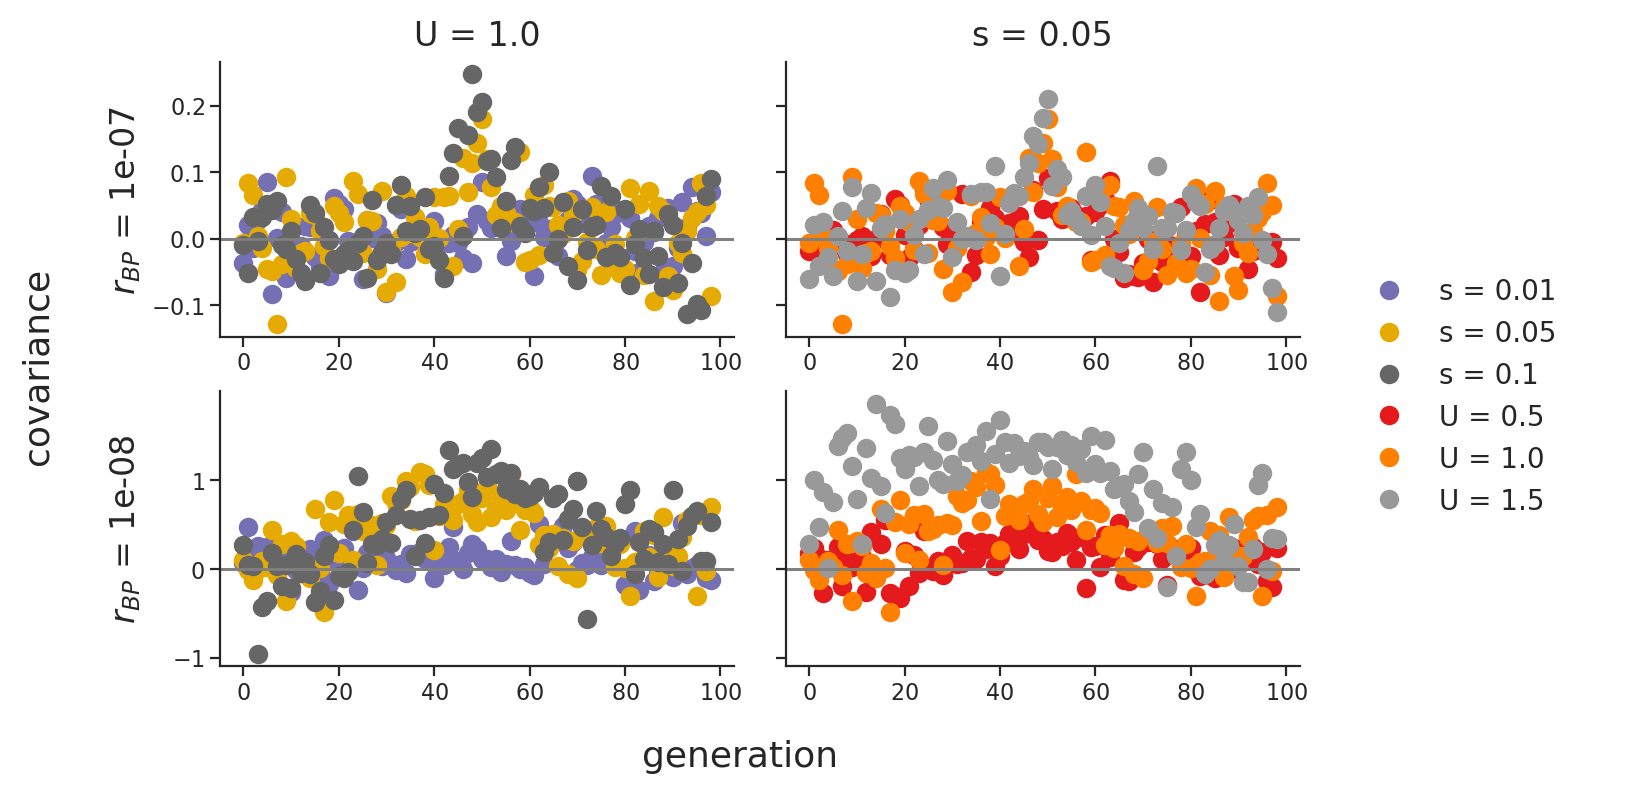

In [66]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharey='row')

maxgen = 100
ref = 50

# crap you need to do because matplotlib...
labset = set()

pad = 0
yscale = 1e2

for i, rbp in enumerate(rbps):
    stacked_results_rbp = extract_runs({'rbp': [rbp]}, stacked_results_wof)

    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['U'] != 1.0 or params['s'] == 0:
            continue
        cov = covs.mean(axis=0)*yscale
        n = cov.shape[0] # assumes these are all the same shape
        idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
        cov_CI = np.quantile(covs*yscale, (0.05, 0.95), axis=0)
        cov_poly = CI_polygon(np.arange(maxgen-1), 
                            cov_CI[0, ref, idx], cov_CI[1, ref, idx],
                            color=s_cols[params['s']], alpha=CI_ALPHA,
                            linewidth=0)

        lab = f"s = {params['s']}" if params['s'] not in labset else ""
        labset.add(params['s'])


        ax[i, 0].plot(cov[ref, idx] *yscale, 'o', c=s_cols[params['s']], label=lab, alpha=1)
        #ax[i, 0].add_patch(cov_poly)    
        #if i > 0:
        #    ax[i, 0].set_xlabel("generation")
        if i == 0:
            ax[i, 0].set_title("U = 1.0")
        #ax[i, 0].set_ylim(-0.00003, 0.00012)
        ax[i, 0].axhline(0, c='0.5', linewidth=1)
    
    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['s'] != 0.05:
            continue
        cov = covs.mean(axis=0) * yscale
        n = cov.shape[0] # assumes these are all the same shape
        idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)    
        cov_CI = np.quantile(covs *  yscale, (0.05, 0.95), axis=0)
        cov_poly = CI_polygon(np.arange(maxgen-1), 
                            cov_CI[0, ref, idx], cov_CI[1, ref, idx],
                            color=U_cols[params['U']], alpha=CI_ALPHA,
                            linewidth=0)

        lab = f"U = {params['U']}" if params['U'] not in labset else ""
        labset.add(params['U'])
        ax[i, 1].plot(cov[ref, idx] * yscale, 'o', c=U_cols[params['U']], label=lab, alpha=1)
        #ax[i, 1].add_patch(cov_poly)        
        #ax[i, 1].legend(frameon=False, ncol=2, loc=(0.1, 0.7))
        #if i > 0:
        #    ax[i, 1].set_xlabel("generation")
        #ax[i, 1].set_ylabel("covariance")
        if i == 0:
            ax[i, 1].set_title("s = 0.05")
        #ax[i, 1].set_ylim(-0.00003, 0.00014)
        #ax[i, 1].set_ylim(-0.00003, 0.00012)
        ax[i, 1].axhline(0, c='0.5', linewidth=1)


        
    ax[i, 0].annotate(f"$r_{{BP}}$ = {rbp}", xy=(-0.15, 0.5), 
                            xycoords="axes fraction",
                            size='large', ha='right', va='center', 
                            rotation=90)

fig.text(0, 0.5, "covariance", va="center", fontsize=13, rotation='vertical')
fig.text(0.45, 0, "generation", ha="center", fontsize=13)
fig.legend(loc = 7, frameon=False, ncol=1)
fig.subplots_adjust(right=0.8, wspace=0.1)
fig.savefig("plots/fig-bgs-covars-without-fixations.pdf", bbox_inches='tight')

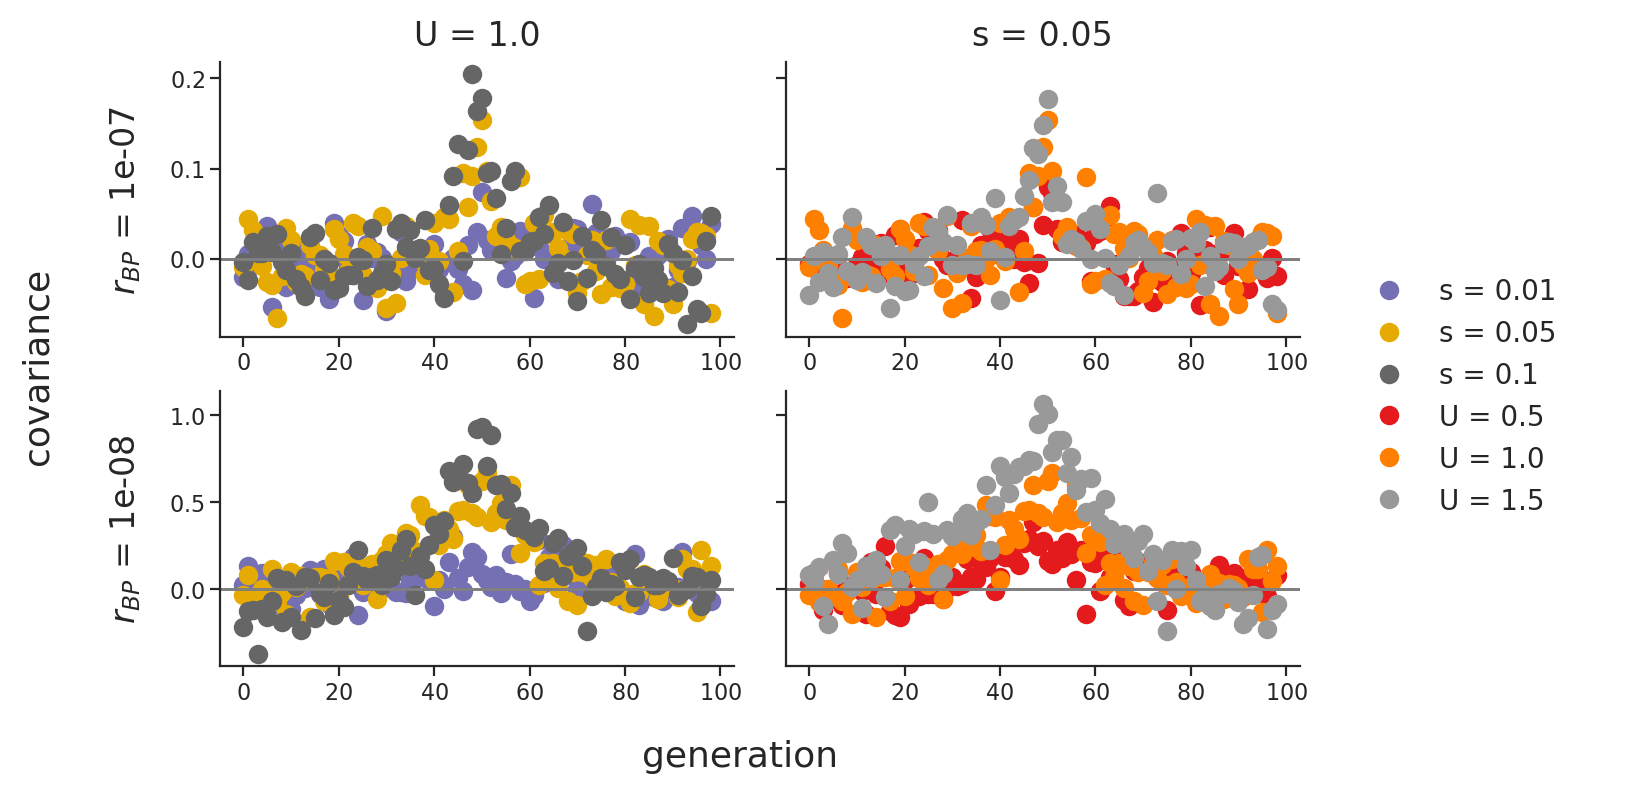

In [65]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharey='row')

maxgen = 100
ref = 50

# crap you need to do because matplotlib...
labset = set()

pad = 0
yscale = 1e2

for i, rbp in enumerate(rbps):
    stacked_results_rbp = extract_runs({'rbp': [rbp]}, stacked_results_wf)

    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['U'] != 1.0 or params['s'] == 0:
            continue
        cov = covs.mean(axis=0)*yscale
        n = cov.shape[0] # assumes these are all the same shape
        idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
        cov_CI = np.quantile(covs*yscale, (0.05, 0.95), axis=0)
        cov_poly = CI_polygon(np.arange(maxgen-1), 
                            cov_CI[0, ref, idx], cov_CI[1, ref, idx],
                            color=s_cols[params['s']], alpha=CI_ALPHA,
                            linewidth=0)

        lab = f"s = {params['s']}" if params['s'] not in labset else ""
        labset.add(params['s'])


        ax[i, 0].plot(cov[ref, idx] *yscale, 'o', c=s_cols[params['s']], label=lab, alpha=1)
        #ax[i, 0].add_patch(cov_poly)    
        #if i > 0:
        #    ax[i, 0].set_xlabel("generation")
        if i == 0:
            ax[i, 0].set_title("U = 1.0")
        #ax[i, 0].set_ylim(-0.00003, 0.00012)
        ax[i, 0].axhline(0, c='0.5', linewidth=1)
    
    for params, (covs, Gs, dims) in sorted(stacked_results_rbp.items(), key=itemgetter(0)):
        params = dict(params)
        if params['s'] != 0.05:
            continue
        cov = covs.mean(axis=0) * yscale
        n = cov.shape[0] # assumes these are all the same shape
        idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)    
        cov_CI = np.quantile(covs *  yscale, (0.05, 0.95), axis=0)
        cov_poly = CI_polygon(np.arange(maxgen-1), 
                            cov_CI[0, ref, idx], cov_CI[1, ref, idx],
                            color=U_cols[params['U']], alpha=CI_ALPHA,
                            linewidth=0)

        lab = f"U = {params['U']}" if params['U'] not in labset else ""
        labset.add(params['U'])
        ax[i, 1].plot(cov[ref, idx] * yscale, 'o', c=U_cols[params['U']], label=lab, alpha=1)
        #ax[i, 1].add_patch(cov_poly)        
        #ax[i, 1].legend(frameon=False, ncol=2, loc=(0.1, 0.7))
        #if i > 0:
        #    ax[i, 1].set_xlabel("generation")
        #ax[i, 1].set_ylabel("covariance")
        if i == 0:
            ax[i, 1].set_title("s = 0.05")
        #ax[i, 1].set_ylim(-0.00003, 0.00014)
        #ax[i, 1].set_ylim(-0.00003, 0.00012)
        ax[i, 1].axhline(0, c='0.5', linewidth=1)


        
    ax[i, 0].annotate(f"$r_{{BP}}$ = {rbp}", xy=(-0.15, 0.5), 
                            xycoords="axes fraction",
                            size='large', ha='right', va='center', 
                            rotation=90)

fig.text(0, 0.5, "covariance", va="center", fontsize=13, rotation='vertical')
fig.text(0.45, 0, "generation", ha="center", fontsize=13)
fig.legend(loc = 7, frameon=False, ncol=1)
fig.subplots_adjust(right=0.8, wspace=0.1)
fig.savefig("plots/fig-bgs-covars-with-fixations.pdf", bbox_inches='tight')

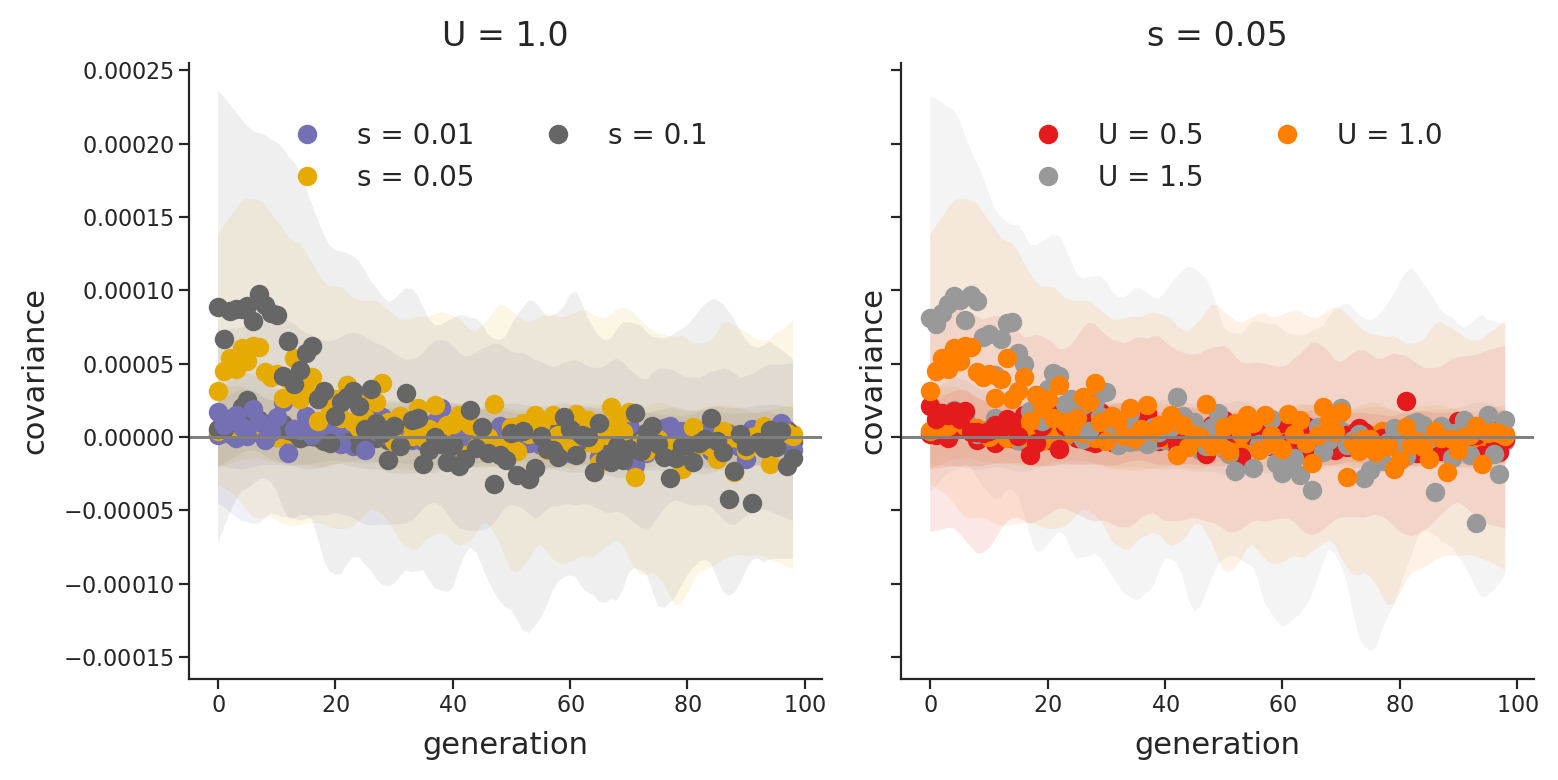

In [64]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharey='row')

maxgen = 100
ref = 5

# crap you need to do because matplotlib...
labset = set()

for params, (covs, Gs, dims) in stacked_results_wf.items():
    params = dict(params)
    if params['U'] != 1.0 or params['s'] == 0:
        continue
    cov = covs.mean(axis=0)
    n = cov.shape[0] # assumes these are all the same shape
    idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
    cov_CI = np.quantile(covs, (0.05, 0.95), axis=0)
    cov_poly = CI_polygon(np.arange(maxgen-1), 
                        cov_CI[0, ref, idx], cov_CI[1, ref, idx],
                        color=s_cols[params['s']], alpha=CI_ALPHA,
                        linewidth=0)
        
    lab = f"s = {params['s']}" if params['s'] not in labset else ""
    labset.add(params['s'])

    
    ax[0].plot(cov[ref, idx], 'o', c=s_cols[params['s']], label=lab, alpha=1)
    ax[0].add_patch(cov_poly)    
    ax[0].legend(frameon=False, ncol=2, loc=(0.055, 0.7))
    ax[0].set_xlabel("generation")
    ax[0].set_ylabel("covariance")
    ax[0].set_title("U = 1.0")
    ax[0].axhline(0, c='0.5', linewidth=1)

labset = set()

for params, (covs, Gs, dims) in stacked_results_wf.items():
    params = dict(params)
    if params['s'] != 0.05:
        continue
    cov = covs.mean(axis=0)
    n = cov.shape[0] # assumes these are all the same shape
    idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)    
    cov_CI = np.quantile(covs, (0.05, 0.95), axis=0)
    cov_poly = CI_polygon(np.arange(maxgen-1), 
                        cov_CI[0, ref, idx], cov_CI[1, ref, idx],
                        color=U_cols[params['U']], alpha=CI_ALPHA,
                        linewidth=0)
        
    lab = f"U = {params['U']}" if params['U'] not in labset else ""
    labset.add(params['U'])
    ax[1].plot(cov[ref, idx], 'o', c=U_cols[params['U']], label=lab, alpha=1)
    ax[1].add_patch(cov_poly)        
    ax[1].legend(frameon=False, ncol=2, loc=(0.1, 0.7))
    ax[1].set_xlabel("generation")
    ax[1].set_ylabel("covariance")
    ax[1].set_title("s = 0.05")
    ax[1].axhline(0, c='0.5', linewidth=1)

plt.tight_layout()

## Split Population BGS Simulations

In [47]:
SPLIT_DATADIR = "../data/sims_intermediate/split_bgs/"
split_bgs_converters = dict(N=int, U=float, nmu=float, rbp=float, s=float,
                            region_length=int, sampleN=int)

split_bgs_results_orig = load_pickled(SPLIT_DATADIR, converters=split_bgs_converters)

In [48]:
split_bgs_results = extract_runs({'s':[0.05]}, split_bgs_results_orig)

In [49]:
split_bgs_params = params_vary_over(split_bgs_results)
split_bgs_params

defaultdict(set,
            {'N': {1000},
             'U': {1.0},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             's': {0.05},
             'sampleN': {50, 100, 200, 1000},
             'smu': {'1e-08'}})

In [50]:
stacked_split_results = average_runs(split_bgs_results, has_corr=True)

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


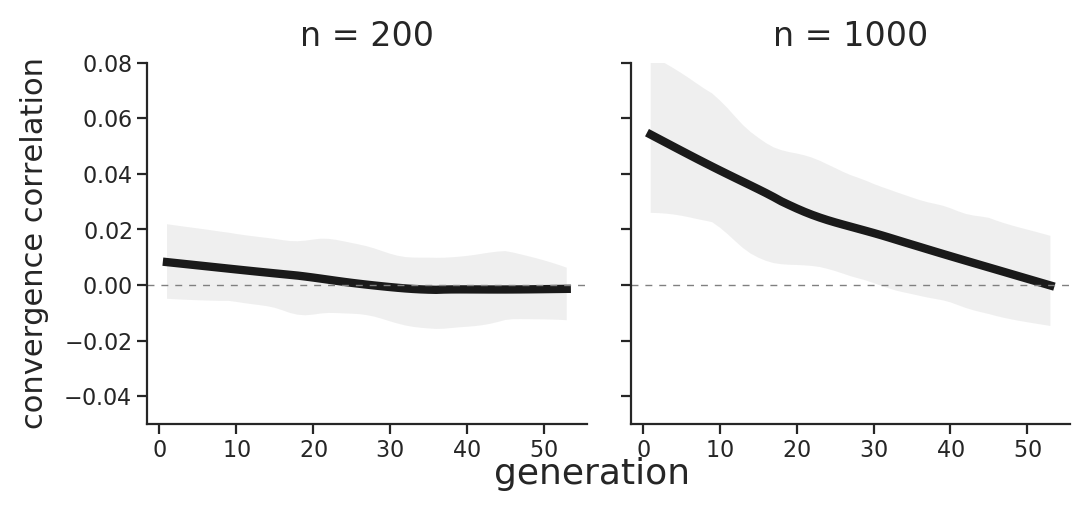

In [57]:
split_bgs_subset = extract_runs({'sampleN':[200, 1000]}, stacked_split_results)
split_bgs_subset_params = params_vary_over(split_bgs_subset)

sampleNs = sorted(split_bgs_subset_params['sampleN'])
ALPHA = 0.05

fig, ax = plt.subplots(nrows = 1, ncols=len(sampleNs), sharey=True,  figsize=(ONECOL*2, ONECOL*0.7))
ref = 0
lightgray, darkgray = (0.6, 0.6, 0.6), (0.1, 0.1, 0.1)

CI_ALPHA = 0.1

for i, sampleN in enumerate(sampleNs):
    d = extract_runs({'sampleN':[sampleN]}, split_bgs_subset)
    assert(len(d) == 1)
    run = list(d.values())[0]
    
    cors = run[2][:, 0, ...]
    cor_ave = cors.mean(axis=0)
    n = cor_ave.shape[0]
    idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
    
    cor_sd = np.sqrt(np.var(cors, axis=0))
    N = cors.shape[0]
    cor_CI = np.stack((cor_ave - 2 * cor_sd/np.sqrt(N), 
                       cor_ave + 2 * cor_sd/np.sqrt(N)))      
    CI_poly = CI_polygon(np.argwhere(idx).squeeze(), 
                         cor_CI[0, idx, 0], cor_CI[1, idx, 0],
                         color='0.4', alpha=CI_ALPHA,
                         smooth=True, frac=1/3,
                         linewidth=0)
    ax[i].add_patch(CI_poly)

    cor_CI = np.quantile(cors, (ALPHA/2, 1-ALPHA/2), axis=0)
    cor_poly = CI_polygon(np.arange(n-1), 
                cor_CI[0, ref, idx], cor_CI[1, ref, idx],
                color='0.4', alpha=CI_ALPHA,
                linewidth=0, smooth=True)
    #ax[i].add_patch(cor_poly)
    lowess = sm.nonparametric.lowess
    z = lowess(cor_ave[ref, idx], np.argwhere(idx).squeeze())
    ax[i].plot(z[:, 0], z[:, 1], '-', c=darkgray, linewidth=3)
    ax[i].set_title(f"n = {sampleN}")
    ax[i].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
    ax[i].set_ylim(-0.05, 0.08)
ax[0].set_ylabel('convergence correlation')
fig.text(0.45, 0, "generation", ha="center", fontsize=13)
fig.subplots_adjust(right=0.8, wspace=0.1)
fig.savefig("plots/fig-bgs-convergence-correlation.pdf", bbox_inches='tight')

## Older Results

These cells aren't meant to be run — just older code / plot reference

In [52]:
ss = dfs['s'].unique()

scols = cm.Dark2(np.linspace(0, 0.5, len(ss)))

for i, s in enumerate(ss):
    subset = (df['U'] == 1.0) & (df['rbp'] == 1e-8)
    idx = np.argwhere((subset & (df['s'] == s)).values)
    assert(idx.shape == (1, 1))
    covs = all_covs[idx[0, 0]]
    for rep_i, (cov, G) in enumerate(covs):
        lab = f"BGS, s={s}" if rep_i == 0 else ""
        plt.plot(G, c=scols[i], label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)

plt.legend(frameon=False)

NameError: name 'dfs' is not defined

In [ ]:
for i, g in enumerate(G_weak_bgs_1e3N):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e3N):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e3N):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

    
for i, g in enumerate(G_semi_1e3N):
    lab = "BGS, s=0.05" if i == 0 else ""
    plt.plot(g, c='purple', label=lab)
    
plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

In [16]:
datadir = '../data/sims/bgs/'
bgs_files = [os.path.join(datadir, f) for f in os.listdir(datadir) if f.startswith('bgs_')]
bgs_stats_files = [f for f in bgs_files if f.endswith('_stats.tsv')]
bgs_nfreqs_files = [f for f in bgs_files if f.endswith('_neutfreqs.tsv')]

In [6]:
sim_stats = [sf.parse_slim_stats(f) for f in bgs_stats_files]

In [7]:
def condense_results(sim_stats, burnin=10000):
    dfs = []
    for sim in sim_stats:
        params = {k: float(v) for k, v in sim.params.items()}
        stats = sim.stats
        dfs.append(pd.concat([stats, pd.DataFrame([params] * len(stats))], axis=1))
    df = pd.concat(dfs)
    return df[df['gen'] > burnin]
bgsdf = condense_results(sim_stats)

In [8]:
bgssum = bgsdf.groupby(['s', 'N', 'rbp', 'U', 'region_length', 'nmu', 'smu']).mean().reset_index()

## Comparision of Total Variance

### N = 1000

In [42]:
nr = 50
datadir = '../data/sims/bgs_orig/'
neut_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:nr]
bgs_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0.1s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:nr]
weak_bgs_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0.01s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:nr]
semi_bgs_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0.05s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:nr]

In [44]:
def freqs_for_cov(frqs, burnin = 10000, gens=150, with_G=True, 
                  fixed_to_nan=False, verbose=True):
    use_masked = fixed_to_nan
    idx = np.array([i for i, time in enumerate(frqs.samples) if 
                    burnin <= time <= burnin + gens])
    samples = [(0, time) for time in idx]
    freqmat = frqs.freqs[idx, :]
    if fixed_to_nan:
        freqmat[np.logical_or(freqmat == 0., freqmat == 1.)] = np.nan
    d = TemporalFreqs(freqmat, samples)
    covs = d.calc_cov(use_masked=use_masked)
    if verbose:
        print(f"done calculating covs...")
    if with_G:
        G = d.calc_G(use_masked=use_masked)
        if verbose:
            print(f"done calculating G...")
        return covs, G, d
    return covs, d

def covs_from_file(file, *args, **kwargs):
    return freqs_for_cov(sf.parse_slim_ragged_freqs(file), *args, **kwargs)


In [45]:
pool = Pool(processes=10)

done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating G...
done calculating G...
done calculating G...
done calculating G...
done calculating G...
done calculating G...
done calculating G...
done calculating G...
done calculating G...
done calculating G...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...
done calculating covs...


In [ ]:
len(bgs_covs_1e3N)

In [ ]:
#bgs_covs = [freqs_for_cov(sf.parse_slim_ragged_freqs(f)) for f in bgs_files]
bgs_covs_1e3N = pool.map(covs_from_file, bgs_files_1e3N)

In [ ]:
#weak_bgs_covs = [freqs_for_cov(sf.parse_slim_ragged_freqs(f)) for f in weak_bgs_files]
weak_bgs_covs_1e3N = pool.map(covs_from_file, weak_bgs_files_1e3N)

In [ ]:
semi_bgs_covs_1e3N = pool.map(covs_from_file, semi_bgs_files_1e3N)

In [ ]:
#neut_covs = [freqs_for_cov(sf.parse_slim_ragged_freqs(f)) for f in neut_files]
neut_covs_1e3N = pool.map(covs_from_file, neut_files_1e3N)

In [ ]:
G_bgs_1e3N = [g for _, g in bgs_covs_1e3N]
G_weak_bgs_1e3N = [g for _, g in weak_bgs_covs_1e3N]
G_neut_1e3N = [g for _, g in neut_covs_1e3N]
G_semi_1e3N = [g for _, g in semi_bgs_covs_1e3N]


for i, g in enumerate(G_weak_bgs_1e3N):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e3N):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e3N):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

    
for i, g in enumerate(G_semi_1e3N):
    lab = "BGS, s=0.05" if i == 0 else ""
    plt.plot(g, c='purple', label=lab)
    
plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

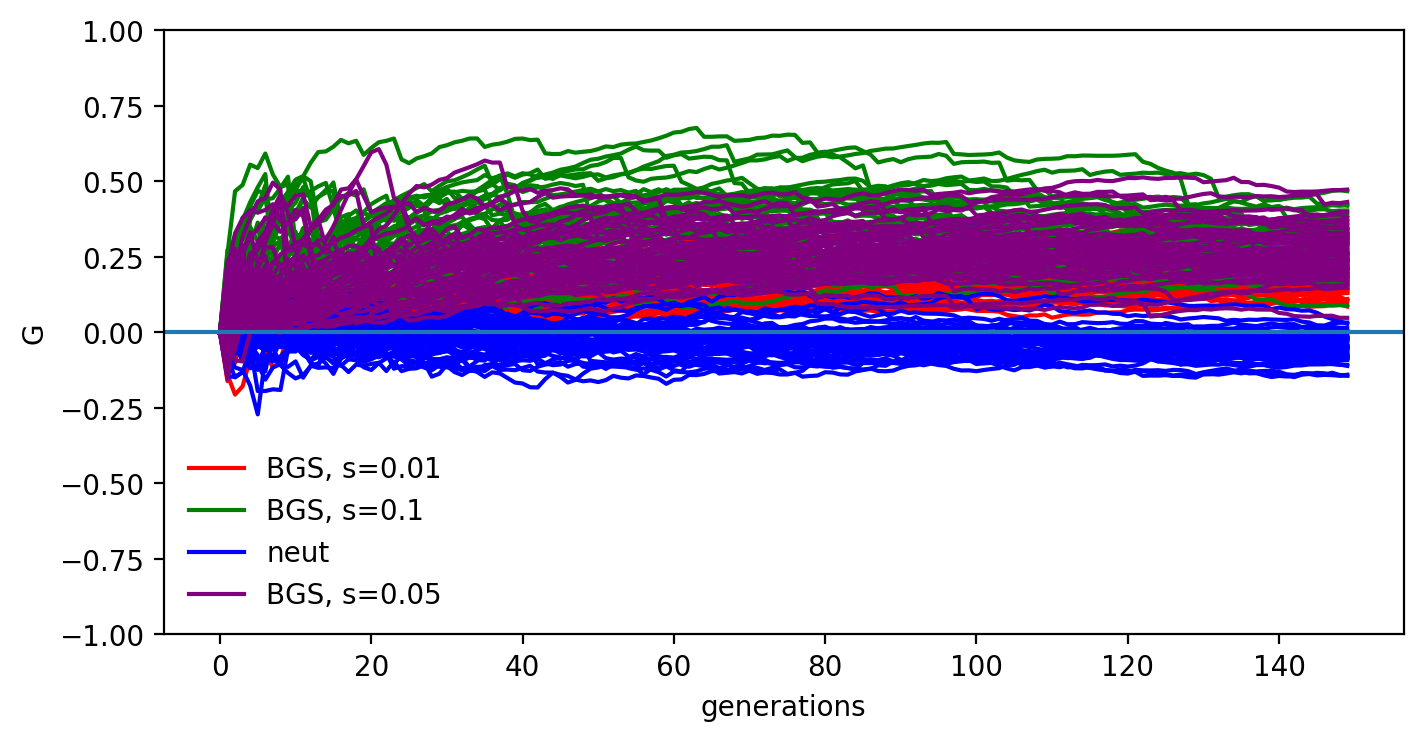

In [146]:
G_bgs_1e3N = [g for _, g in bgs_covs_1e3N]
G_weak_bgs_1e3N = [g for _, g in weak_bgs_covs_1e3N]
G_neut_1e3N = [g for _, g in neut_covs_1e3N]
G_semi_1e3N = [g for _, g in semi_bgs_covs_1e3N]


for i, g in enumerate(G_weak_bgs_1e3N):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e3N):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e3N):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

    
for i, g in enumerate(G_semi_1e3N):
    lab = "BGS, s=0.05" if i == 0 else ""
    plt.plot(g, c='purple', label=lab)
    
plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

## Covariance Decays

In [147]:
covs_bgs_1e3N = np.array([c for c, _ in bgs_covs_1e3N]).mean(axis=0)
covs_weak_bgs_1e3N = np.array([c for c, _ in weak_bgs_covs_1e3N]).mean(axis=0)
covs_neut_1e3N = np.array([c for c, _ in neut_covs_1e3N]).mean(axis=0)
covs_semi_bgs_1e3N = np.array([c for c, _ in semi_bgs_covs_1e3N]).mean(axis=0)

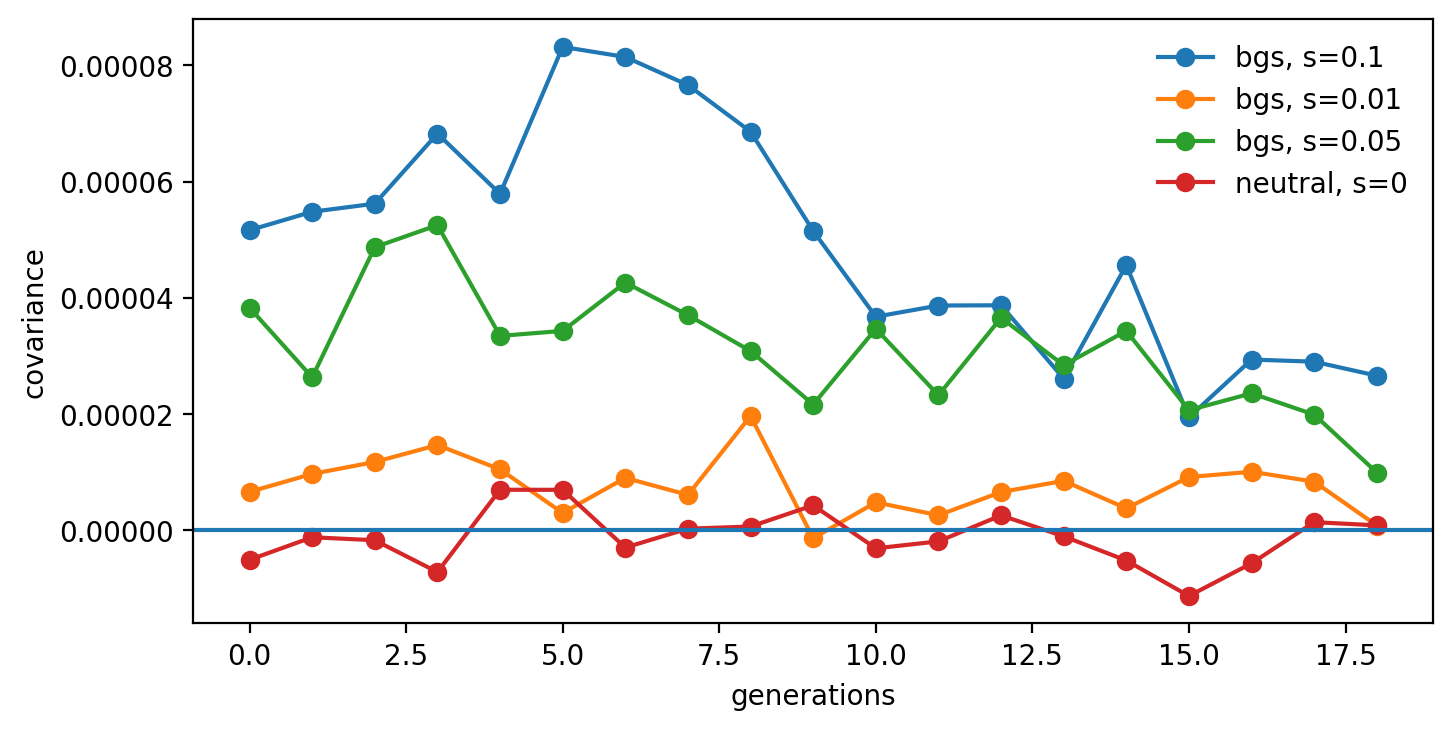

In [150]:
n = covs_bgs_1e3N[0].shape[0] # assumes these are all the same shape

ref = 5
idx = (np.arange(n) != ref) & (np.arange(n) < 20)


plt.plot(covs_bgs_1e3N[ref, idx], '-o',  label='bgs, s=0.1')

plt.plot(covs_weak_bgs_1e3N[ref, idx], '-o', label='bgs, s=0.01')
plt.plot(covs_semi_bgs_1e3N[ref, idx], '-o', label='bgs, s=0.05')

plt.plot(covs_neut_1e3N[ref, idx], '-o', label='neutral, s=0')


plt.ylabel('covariance')
plt.xlabel('generations')
plt.axhline(0)
plt.legend(frameon=False)

### With N = 100

With N = 100, fixations occur over a very short timescale. As such, this leads to negative covariance, an artifact of the method, when one does not mark fixations and losses as NaNs. Thus, below we use remove these. 

Note that one also needs to ignore fixed sites when calculating the level of variance for inferring Ne. In this case, fixed/loss sites have allele frequency change zero, and shrink the value towards zero.



In [17]:
neut_files_1e2N = sorted(glob.glob(datadir + "bgs_100N_1e-08rbp_0s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]
bgs_files_1e2N = sorted(glob.glob(datadir + "bgs_100N_1e-08rbp_0.1s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]
weak_bgs_files_1e2N = sorted(glob.glob(datadir + "bgs_100N_1e-08rbp_0.01s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]

In [81]:
pool = Pool(processes=10)

In [19]:
# a temporary wrapper for these parameters
covs_from_file_wrapped = partial(covs_from_file, burnin=1000, fixed_to_nan=True)

bgs_covs_1e2N = pool.map(covs_from_file_wrapped, bgs_files_1e2N)

In [20]:
weak_bgs_covs_1e2N = pool.map(covs_from_file_wrapped, weak_bgs_files_1e2N)

In [21]:
neut_covs_1e2N = pool.map(covs_from_file_wrapped, neut_files_1e2N)

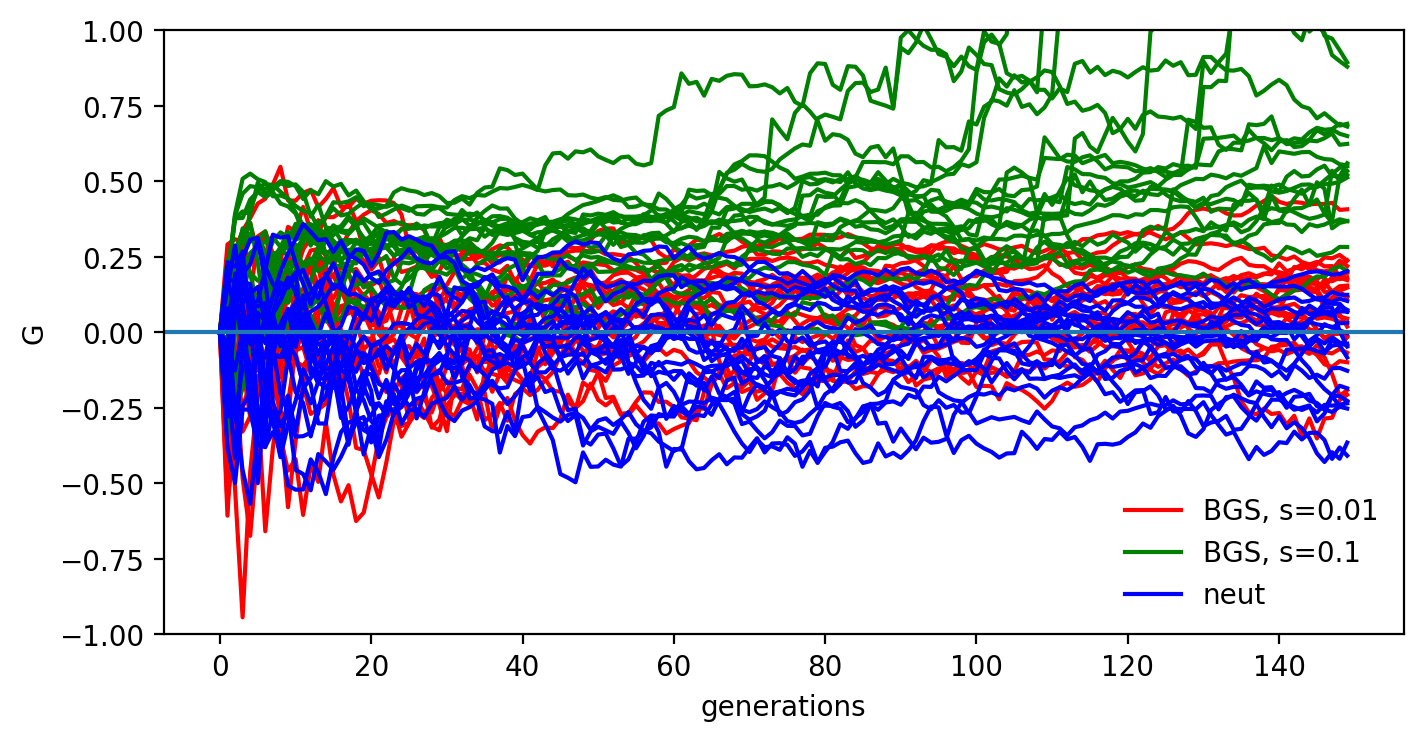

In [22]:
G_bgs_1e2N = [g for _, g in bgs_covs_1e2N]
G_weak_bgs_1e2N = [g for _, g in weak_bgs_covs_1e2N]
G_neut_1e2N = [g for _, g in neut_covs_1e2N]

for i, g in enumerate(G_weak_bgs_1e2N):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e2N):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e2N):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

### Without removing fixations

In [23]:
# a temporary wrapper for these parameters
covs_from_file_wrapped_withfix = partial(covs_from_file, burnin=1000, fixed_to_nan=False)

bgs_covs_1e2N_fix = pool.map(covs_from_file_wrapped_withfix, bgs_files_1e2N)

In [24]:
weak_bgs_covs_1e2N_fix = pool.map(covs_from_file_wrapped_withfix, weak_bgs_files_1e2N)

In [25]:
neut_covs_1e2N_fix = pool.map(covs_from_file_wrapped_withfix, neut_files_1e2N)

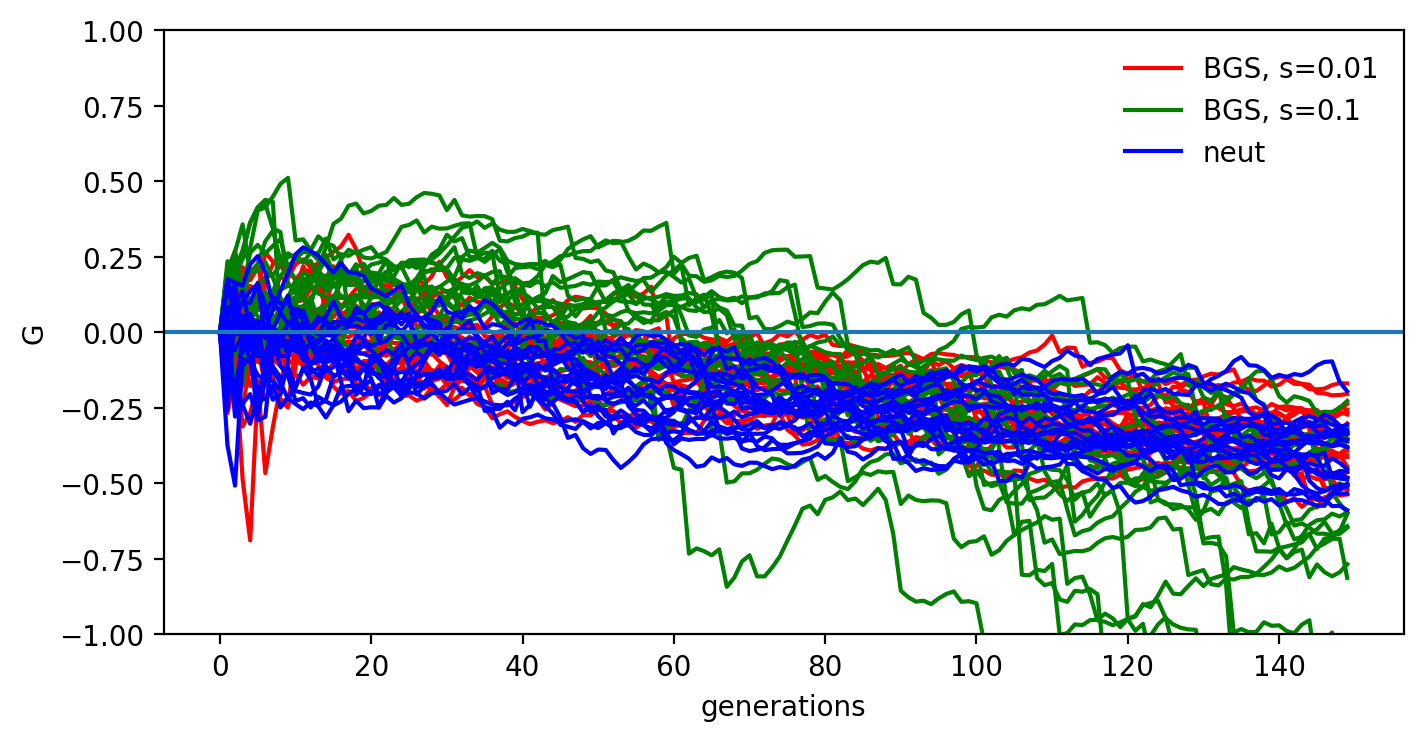

In [26]:
G_bgs_1e2N_fix = [g for _, g in bgs_covs_1e2N_fix]
G_weak_bgs_1e2N_fix = [g for _, g in weak_bgs_covs_1e2N_fix]
G_neut_1e2N_fix = [g for _, g in neut_covs_1e2N_fix]

for i, g in enumerate(G_weak_bgs_1e2N_fix):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e2N_fix):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e2N_fix):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

This shows how much processing fixations differently can affect things.

Maybe, replace fixations with NaNs, the sites contributiong to the long run covariances are those with really long fixation times. This implies they must have more "balanced" drifts – maybe this creates negative covariance? 

In [ ]:
G_bgs = [g for _, g in bgs_covs]
G_weak_bgs = [g for _, g in weak_bgs_covs]
G_neut = [g for _, g in neut_covs]

for i, g in enumerate(G_weak_bgs):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)

plt.legend(frameon=False)

## Fixation Times

In [ ]:
neut_freqs_1e2N = [sf.parse_slim_ragged_freqs(f) for f in neut_files_1e2N]

In [70]:
def conditioned_covs(frqs, threshold, type='min', burnin = 1000, 
                     gens=150, with_G=True,):
    seg_gens = np.logical_and(frqs.freqs > 0, frqs.freqs < 1).sum(axis=0)
    
    idx = np.array([i for i, time in enumerate(frqs.samples) if 
                    burnin <= time <= burnin + gens])
    samples = [(0, time) for time in idx]
    # 
    cond = seg_gens > threshold if type == 'min' else seg_gens < threshold
    freqmat = frqs.freqs[idx, :][:, cond]
    d = TemporalFreqs(freqmat, samples)
    if with_G:
        return d.calc_cov(), d.calc_G()
    return d.calc_cov()

(array([13912.,   958.,   348.,   209.,   152.,   100.,    52.,    62.,
           49.,   325.]),
 array([  1.,  16.,  31.,  46.,  61.,  76.,  91., 106., 121., 136., 151.]),
 <a list of 10 Patch objects>)

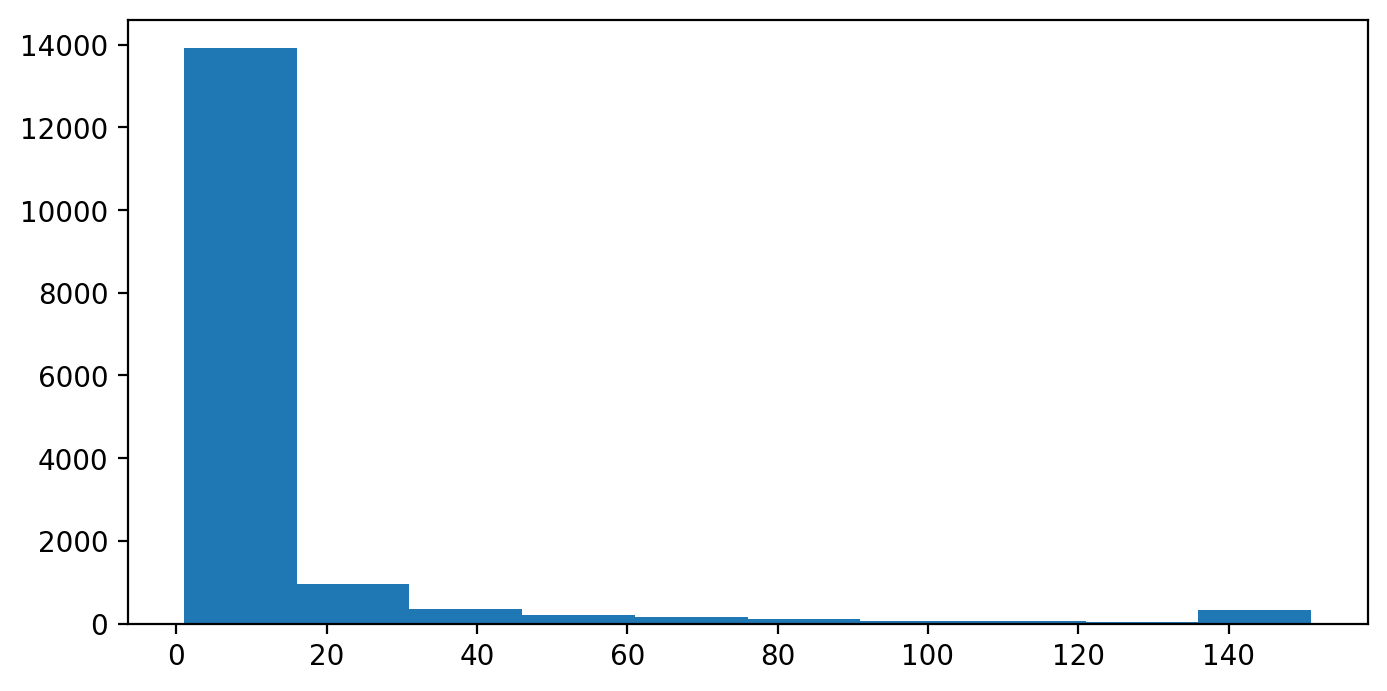

In [50]:
seg_gens = np.logical_and(neut_freqs_1e2N[0].freqs > 0, neut_freqs_1e2N[0].freqs < 1).sum(axis=0)

plt.hist(seg_gens[seg_gens > 0])

In [76]:
conditioned_slow = []
conditioned_fast = []
not_conditioned = []

for i in range(10):
    conditioned_slow.append(conditioned_covs(neut_freqs_1e2N[i], 140, 'min'))
    #conditioned_fast.append(conditioned_covs(neut_freqs_1e2N[i], 10, 'max'))
    not_conditioned.append(conditioned_covs(neut_freqs_1e2N[i], 0))

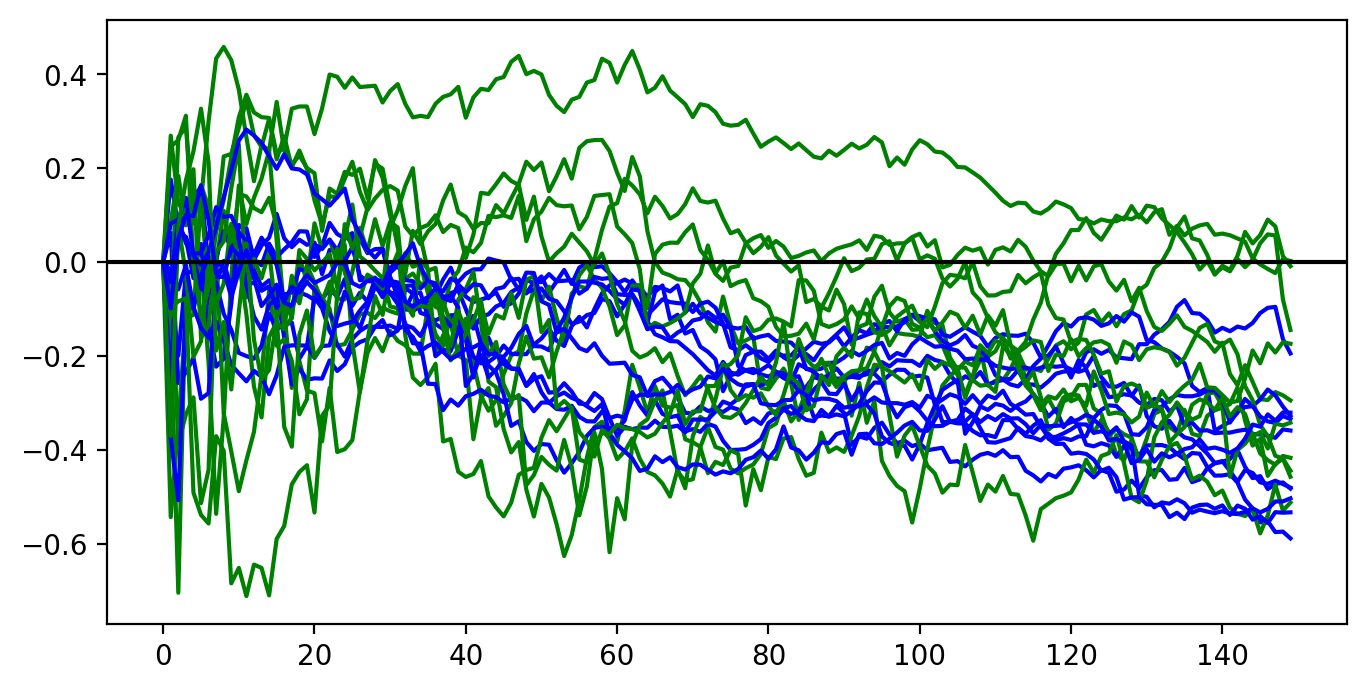

In [80]:
for i in range(10):
    #plt.plot(conditioned_fast[i][1], c='r')
    plt.plot(conditioned_slow[i][1], c='g')
    plt.plot(not_conditioned[i][1], c='b')
plt.axhline(0, c='k')

In [84]:
bgs_freqs_1e2N = [sf.parse_slim_ragged_freqs(f) for f in bgs_files_1e2N]

In [93]:
bgs_conditioned_slow = []
bgs_not_conditioned = []

for i in range(10):
    bgs_conditioned_slow.append(conditioned_covs(bgs_freqs_1e2N[i], 140, 'min'))
    #conditioned_fast.append(conditioned_covs(neut_freqs_1e2N[i], 10, 'max'))
    bgs_not_conditioned.append(conditioned_covs(bgs_freqs_1e2N[i], 0))

/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(30) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(10) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(9) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(23) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(17) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(15) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matri

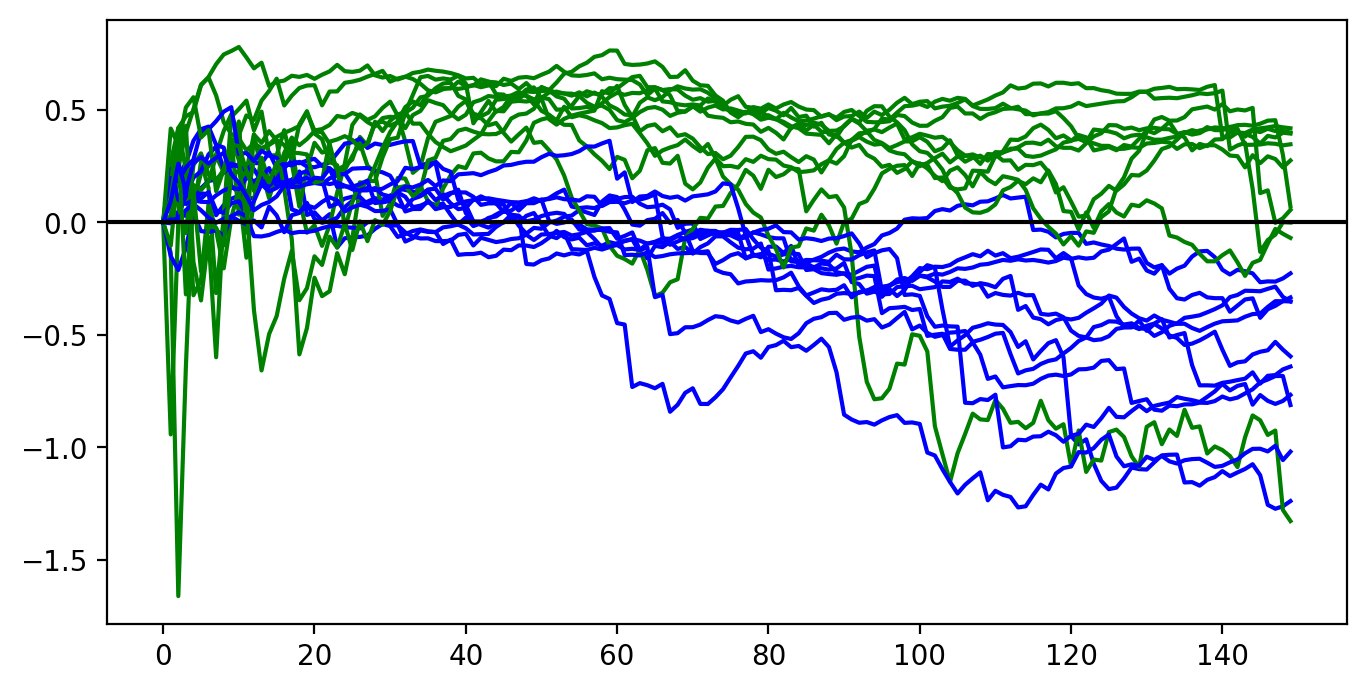

In [94]:
for i in range(10):
    #plt.plot(conditioned_fast[i][1], c='r')
    plt.plot(bgs_conditioned_slow[i][1], c='g')
    plt.plot(bgs_not_conditioned[i][1], c='b')
plt.axhline(0, c='k')

In [158]:
print(f"s = 0.1, mean vars = {np.round(np.sum([np.diag(c).mean() for c, g in bgs_covs]), 3)}\n" + 
  covs_from_file = 0.01, mean vars = {np.round(np.sum([np.diag(c).mean() for c, g in weak_bgs_covs]),3)}\n" + 
      f"s = 0.00, mean vars = {np.round(np.sum([np.diag(c).mean() for c, g in neut_covs]),3)}")

s = 0.1, mean vars = 0.038
s = 0.01, mean vars = 0.023
s = 0.00, mean vars = 0.009


In [159]:
print(
f"s = 0.1, mean sum of covs = {np.round(np.mean([c[np.triu_indices(c.shape[1], k=1)].sum() for c, g in bgs_covs]), 4)}\n" + 
f"s = 0.01, mean sum of covs = {np.round(np.mean([c[np.triu_indices(c.shape[1], k=1)].sum() for c, g in weak_bgs_covs]), 4)}\n" + 
f"s = 0.00, mean sum of covs = {np.round(np.mean([c[np.triu_indices(c.shape[1], k=1)].sum() for c, g in neut_covs]), 4)}")


s = 0.1, mean sum of covs = 0.0504
s = 0.01, mean sum of covs = 0.0122
s = 0.00, mean sum of covs = 0.0002


```
# sum of diagonals (variances), averaged across replicates
s = 0.1, mean vars = 0.038
s = 0.01, mean vars = 0.023
s = 0.00, mean vars = 0.009

# sum of upper triangle (covariances), averaged across replicates
s = 0.1, mean sum of covs = 0.0504
s = 0.01, mean sum of covs = 0.0122
s = 0.00, mean sum of covs = 0.0002

```

In [167]:
(0.5 * 60) / 0.009

3333.3333333333335